In [47]:
# necessary imports
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.multivariate.manova import MANOVA

# Loading Data

In [72]:
P = {} # df per Participant
data_dir = "clean_data"
for csv_file in os.listdir(data_dir):
    if csv_file.startswith("P"): # Only get Participant Directories
        pn = int(csv_file[1:-4])
        tmp = pd.read_csv(os.path.join(data_dir,csv_file))
        tmp["participant"] = pn
        P[pn] = tmp
df = pd.concat(P.values(), axis = 0).dropna()# all data

In [3]:
P[1].sample()

,timestamp,app_name,app_category,brightness,uv_intensity,longitude,latitude,altitude,at_home,valence,arousal,attention,stress,participant
42,2019-05-11 19:53:24.193000+09:00,YouTube,VIDEO_PLAYERS,0,NONE,34.305991,36.315284,95.0,False,3,3,-1,-2,1


In [4]:
df.sample()

,timestamp,app_name,app_category,brightness,uv_intensity,longitude,latitude,altitude,at_home,valence,arousal,attention,stress,participant
162,2019-05-16 20:21:40.457000+09:00,네이버 웹툰,COMICS,0.0,NONE,34.307737,36.393248,93.157262,False,0.0,-2.0,1.0,-1.0,42


In [14]:
df["uv_intensity"].unique()

array(['NONE', 'LOW', nan, 'MEDIUM'], dtype=object)

In [35]:
df.isna().sum()

timestamp          0
app_name           0
app_category       0
brightness      2069
uv_intensity    2095
longitude        669
latitude         669
altitude         669
at_home            0
valence         2665
arousal         2665
attention       2665
stress          2665
participant        0
dtype: int64

In [33]:
df[df["at_home"] & (df["uv_intensity"]=='LOW')]

,timestamp,app_name,app_category,brightness,uv_intensity,longitude,latitude,altitude,at_home,valence,arousal,attention,stress,participant
527,2019-05-13 19:09:10.063000+09:00,Facebook,SOCIAL,13089.0,LOW,34.316315,36.362699,82.900002,True,-2.0,-2.0,-2.0,3.0,3
528,2019-05-13 19:44:07.471000+09:00,Instagram,SOCIAL,13089.0,LOW,34.316315,36.362699,82.900002,True,-2.0,-2.0,-2.0,3.0,3
533,2019-05-14 04:55:36.218000+09:00,Facebook,SOCIAL,13089.0,LOW,34.316304,36.362707,80.300003,True,-2.0,-2.0,-2.0,3.0,3
539,2019-05-14 09:49:13.220000+09:00,Facebook,SOCIAL,13089.0,LOW,34.316295,36.362680,82.900002,True,-2.0,-2.0,-2.0,3.0,3
540,2019-05-14 10:45:05.119000+09:00,Facebook,SOCIAL,13089.0,LOW,34.316336,36.362685,73.900002,True,-2.0,-2.0,-2.0,3.0,3
2418,2019-05-03 12:34:46.717000+09:00,Instagram,SOCIAL,4553.0,LOW,34.324485,36.370946,0.000000,True,0.0,1.0,1.0,-3.0,55
2419,2019-05-03 12:34:48.016000+09:00,Instagram,SOCIAL,16756.0,LOW,34.324485,36.370946,0.000000,True,0.0,1.0,1.0,-3.0,55
418,2019-05-17 12:15:41.064000+09:00,Facebook,SOCIAL,47.0,LOW,34.314656,36.373763,95.000000,True,-2.0,-3.0,-1.0,1.0,39


In [37]:
df.groupby("app_category")["brightness"].mean().sort_values(ascending=False)

app_category
MUSIC_AND_AUDIO        415.635405
NEWS_AND_MAGAZINES     297.871111
BOOKS_AND_REFERENCE    156.267016
SOCIAL                 154.765189
GAME                   135.063823
VIDEO_PLAYERS          120.148706
LIBRARIES_AND_DEMO     116.788497
SHOPPING               108.412797
SPORTS                 106.955293
ENTERTAINMENT          106.463410
COMICS                  74.033785
Name: brightness, dtype: float64

# Descriptive Statistics

## Frequency Distribution

In [5]:
at_home_dist = df[df["at_home"]]["app_category"].value_counts() / df[df["at_home"]].shape[0]
not_at_home_dist = df[~df["at_home"]]["app_category"].value_counts() / df[~df["at_home"]].shape[0]

In [6]:
dist_df = pd.DataFrame({"at_home":at_home_dist, "not_at_home":not_at_home_dist})
dist_df.sort_values(by=["at_home","not_at_home"], ascending=False)

,at_home,not_at_home
app_category,,
SOCIAL,0.445555,0.556331
VIDEO_PLAYERS,0.161583,0.067308
ENTERTAINMENT,0.099935,0.071491
BOOKS_AND_REFERENCE,0.093056,0.049836
GAME,0.061648,0.033036
MUSIC_AND_AUDIO,0.052563,0.066590
SHOPPING,0.032836,0.050743
COMICS,0.031149,0.090830
SPORTS,0.013368,0.007711


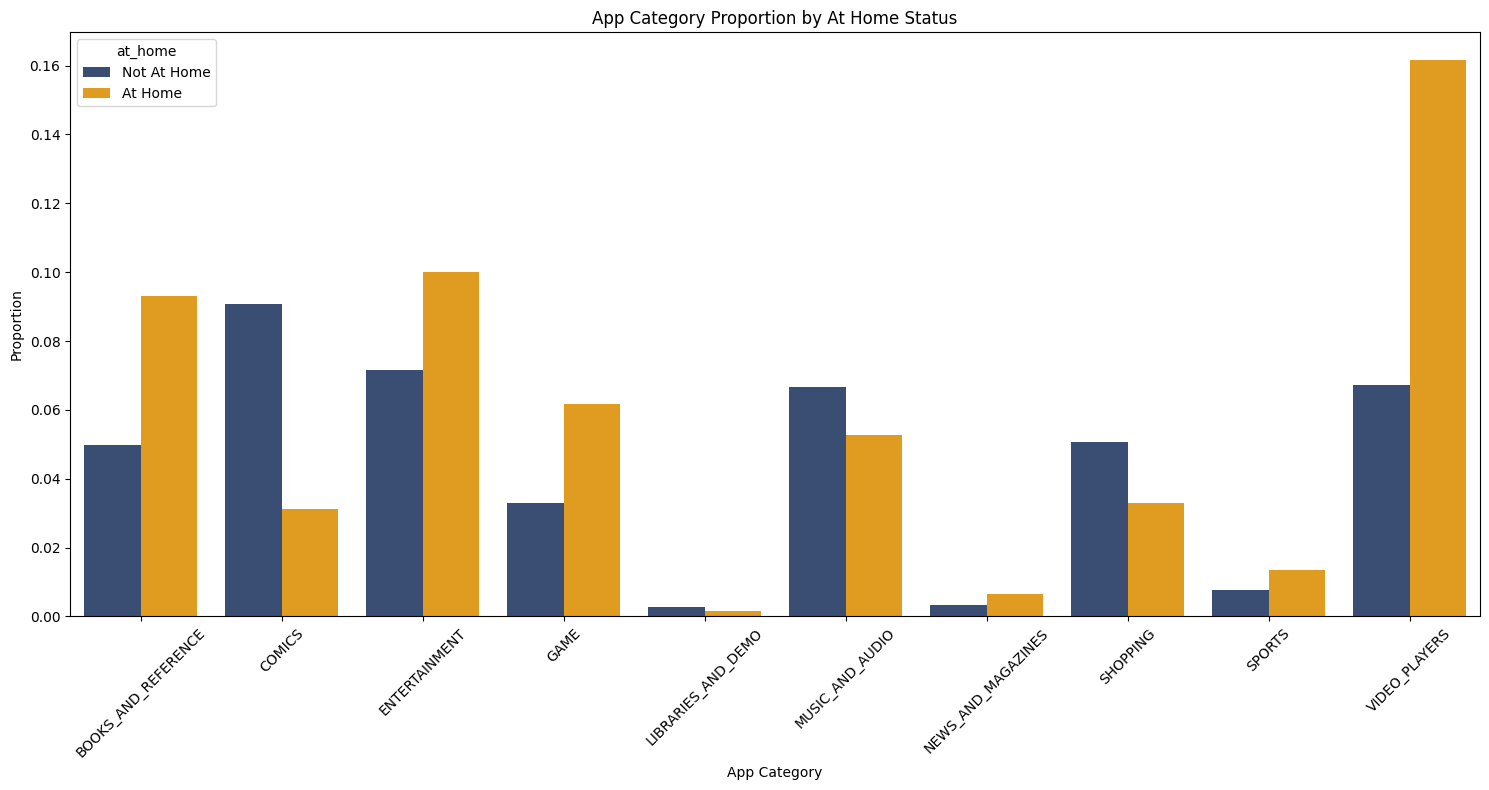

In [7]:

# Calculate the distributions
at_home_dist = df[df["at_home"]]["app_category"].value_counts()[1:] / df[df["at_home"]].shape[0]
not_at_home_dist = df[~df["at_home"]]["app_category"].value_counts()[1:] / df[~df["at_home"]].shape[0]

# Create a DataFrame for plotting
dist_df = pd.DataFrame({
    'app_category': at_home_dist.index.tolist() + not_at_home_dist.index.tolist(),
    'proportion': at_home_dist.tolist() + not_at_home_dist.tolist(),
    'at_home': ['At Home'] * len(at_home_dist) + ['Not At Home'] * len(not_at_home_dist)
}).sort_values(by=["proportion"], ascending=False)

# Sort the DataFrame by app_category
dist_df = dist_df.sort_values(by=['app_category', 'at_home'], ascending=[True, False])

# Plot the data
plt.figure(figsize=(15, 8))
sns.barplot(x='app_category', y='proportion', hue='at_home', data=dist_df, palette=['#2f4b7c', '#ffa600'])
plt.xlabel('App Category')
plt.ylabel('Proportion')
plt.title('App Category Proportion by At Home Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Means and Standard Deviations

In [8]:
df.describe()

,brightness,longitude,latitude,altitude,valence,arousal,attention,stress,participant
count,196400.000000,197800.000000,197800.000000,197800.000000,195804.000000,195804.000000,195804.000000,195804.000000,198469.000000
mean,155.833182,34.297208,36.415217,80.819327,0.610335,-0.190440,0.279080,-0.454398,41.101573
std,1156.035375,2.298244,0.349769,28.285244,1.334339,1.555744,1.563702,1.563806,22.060308
min,0.000000,-243.254757,35.096366,-132.824455,-3.000000,-3.000000,-3.000000,-3.000000,1.000000
25%,3.000000,34.314700,36.368086,75.000000,0.000000,-2.000000,-1.000000,-2.000000,21.000000
50%,29.000000,34.316147,36.370696,84.699997,1.000000,0.000000,0.000000,-1.000000,43.000000
75%,85.000000,34.320567,36.373927,95.300003,2.000000,1.000000,1.000000,1.000000,57.000000
max,65535.000000,36.250271,37.709008,1151.584606,3.000000,3.000000,3.000000,3.000000,80.000000


# Inferential Statistics

A. Chi-Square Test of Independence

    Objective: To test if there is an association between the environmental setting (home vs. outdoors) and the type of app used.
    Variables:
        Independent Variable: Environmental Setting (Home vs. Outdoors)
        Dependent Variable: Type of App (Games, Social Media, Classic Entertainment)
    Test: Chi-Square Test of Independence.

B. Multinomial Logistic Regression

    Objective: To examine the influence of environmental setting on the likelihood of choosing different types of apps while controlling for other variables.
    Variables:
        Dependent Variable: Type of App (categorical with three levels: Games, Social Media, Classic Entertainment)
        Independent Variables: Environmental Setting, Stress Levels, Valence, Arousal, Attention
    Test: Multinomial Logistic Regression.

C. t-Tests and ANOVA

    Objective: To compare the stress levels, valence, and arousal between different settings and app types.
    Tests:
        t-Tests: Compare mean stress levels, valence, and arousal between two groups (home vs. outdoors).
        ANOVA: Compare mean stress levels, valence, and arousal across multiple groups (different app types).

D. Mixed-Effects Model

    Objective: To account for the repeated measures design, considering that multiple observations come from the same participants.
    Variables:
        Fixed Effects: Environmental Setting, Type of App
        Random Effects: Participant ID
        Dependent Variables: Stress Levels, Valence, Arousal
    Test: Mixed-Effects Model.

# Correlation and Mediation Analysis

A. Correlation Analysis

    Objective: To explore the relationships between stress levels, valence, arousal, and app usage in different settings.
    Variables: Stress Levels, Valence, Arousal, Type of App, Environmental Setting
    Test: Pearson or Spearman Correlation Coefficients.

B. Mediation Analysis

    Objective: To examine if the relationship between environmental setting and stress levels is mediated by the type of app used.
    Variables:
        Independent Variable: Environmental Setting
        Mediator: Type of App
        Dependent Variable: Stress Levels
    Test: Mediation Analysis using regression techniques.

In [99]:
# Convert app_category to numerical values
app_category_num = df["app_category"].apply(lambda x: cat_to_num[x])

# Convert at_home to integers
at_home_int = df["at_home"].astype(int)

# Combine the two series into a NumPy array
np.column_stack((app_category_num, at_home_int))

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [100]:
cats = df["app_category"].unique()
cat_to_num = {cats[i]:i for i in range(len(cats))}
app_category_num = df["app_category"].apply(lambda x: cat_to_num[x])
at_home_int = df["at_home"].astype(int)
X = np.column_stack((app_category_num, at_home_int))
y = np.array(df[["attention", "stress","arousal","valence"]])

X.dtype, y.dtype

(dtype('int64'), dtype('float64'))

In [105]:
pg.rm_anova(data=df, dv="attention",within=["app_category", "at_home"],subject="participant")

/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/pingouin/parametric.py:747: RuntimeWarning: invalid value encountered in double_scalars
  f_a = ms_a / ms_as
/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/pingouin/parametric.py:748: RuntimeWarning: invalid value encountered in double_scalars
  f_b = ms_b / ms_bs
/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/pingouin/parametric.py:749: RuntimeWarning: invalid value encountered in double_scalars
  f_ab = ms_ab / ms_abs
/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/pingouin/parametric.py:764: RuntimeWarning: invalid value encountered in double_scalars
  ef_a = ss_a / (ss_a + ss_s + ss_as + ss_bs + ss_abs)
/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/pingouin/parametric.py:765: RuntimeWarning: invalid value encountered in double_scalars
  ef_b = ss_b / (ss_b + ss_s + ss_as + ss_bs + ss

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,app_category,0.0,-1,1,-0.0,NaN,NaN,NaN,NaN,1.0
1,at_home,0.0,-1,1,-0.0,NaN,NaN,NaN,NaN,1.0
2,app_category * at_home,0.0,1,-1,0.0,NaN,NaN,NaN,NaN,NaN


In [108]:
display(df.head())
display(df.describe(include='all'))
display(df.isnull().sum())

,timestamp,app_name,app_category,brightness,uv_intensity,longitude,latitude,altitude,at_home,valence,arousal,attention,stress,participant
0,2019-05-08 09:13:10.567000+09:00,Facebook,SOCIAL,0.0,NONE,34.320602,36.370015,76.000000,False,2.0,2.0,2.0,-2.0,19
1,2019-05-08 09:15:26.932000+09:00,Facebook,SOCIAL,0.0,NONE,34.320648,36.369990,75.000000,False,2.0,2.0,2.0,-2.0,19
2,2019-05-08 09:18:10.261000+09:00,Facebook,SOCIAL,63.0,NONE,34.320564,36.370210,84.400002,False,2.0,2.0,2.0,-2.0,19
3,2019-05-08 09:19:48.977000+09:00,Facebook,SOCIAL,0.0,NONE,34.320564,36.370210,84.400002,False,2.0,2.0,2.0,-2.0,19
4,2019-05-08 09:21:43.377000+09:00,Facebook,SOCIAL,0.0,NONE,34.320639,36.370090,66.000000,False,2.0,2.0,2.0,-2.0,19


,timestamp,app_name,app_category,brightness,uv_intensity,longitude,latitude,altitude,at_home,valence,arousal,attention,stress,participant
count,195080,195080,195080,195080.000000,195080,195080.000000,195080.000000,195080.000000,195080,195080.000000,195080.000000,195080.000000,195080.000000,195080.000000
unique,195062,288,11,NaN,3,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,2019-05-02 19:12:46.132000+09:00,Facebook,SOCIAL,NaN,NONE,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
freq,2,46992,107525,NaN,193991,NaN,NaN,NaN,187586,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,154.032161,NaN,34.296887,36.415838,80.737653,NaN,0.608222,-0.192460,0.279188,-0.454731,41.160642
std,NaN,NaN,NaN,1157.189753,NaN,2.314209,0.352158,28.407890,NaN,1.333983,1.554563,1.562764,1.562909,22.036558
min,NaN,NaN,NaN,0.000000,NaN,-243.254757,35.096366,-132.824455,NaN,-3.000000,-3.000000,-3.000000,-3.000000,1.000000
25%,NaN,NaN,NaN,3.000000,NaN,34.314669,36.368086,75.000000,NaN,0.000000,-2.000000,-1.000000,-2.000000,21.000000
50%,NaN,NaN,NaN,29.000000,NaN,34.316049,36.370716,84.599998,NaN,1.000000,0.000000,0.000000,-1.000000,43.000000
75%,NaN,NaN,NaN,83.000000,NaN,34.320555,36.373941,95.300003,NaN,2.000000,1.000000,1.000000,1.000000,57.000000


timestamp       0
app_name        0
app_category    0
brightness      0
uv_intensity    0
longitude       0
latitude        0
altitude        0
at_home         0
valence         0
arousal         0
attention       0
stress          0
participant     0
dtype: int64

In [101]:
manova = MANOVA(endog=X,exog=y)

In [102]:
print(manova.mv_test())

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
            x0           Value  Num DF    Den DF   F Value  Pr > F
------------------------------------------------------------------
           Wilks' lambda 0.9938 2.0000 195075.0000 610.5393 0.0000
          Pillai's trace 0.0062 2.0000 195075.0000 610.5393 0.0000
  Hotelling-Lawley trace 0.0063 2.0000 195075.0000 610.5393 0.0000
     Roy's greatest root 0.0063 2.0000 195075.0000 610.5393 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
            x1           Value  Num DF    Den DF   F Value  Pr > F
------------------------------------------------------------------
           Wilks' lambda 0.9925 2.0000 195075.0000 733.5803 0.0000
          Pillai

/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
